In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 256 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_256____2020_08_09_22_05_58_228942_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Augmentation

In [11]:
import tensorflow_addons as tfa
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.6, upper=1.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.05, seed=None)
    #image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.2, maxval=.2)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (8,8), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

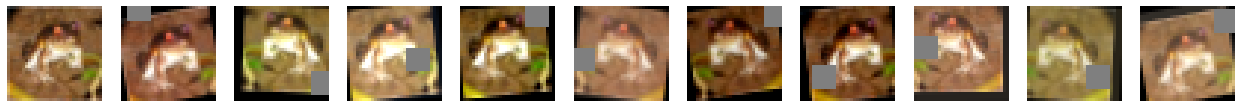

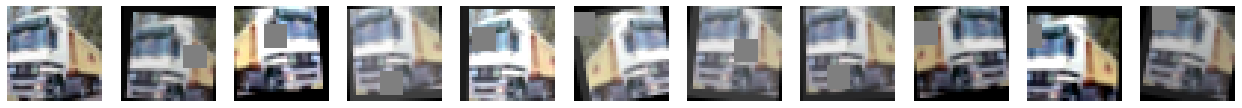

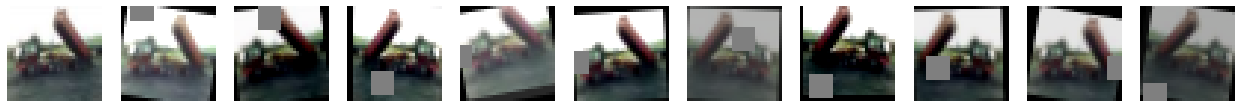

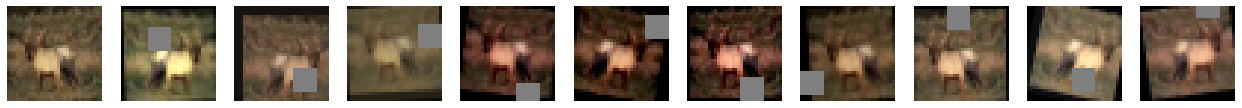

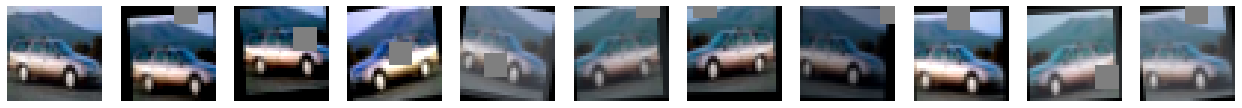

In [12]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

### train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [14]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(tf.keras.optimizers.Adam(1e-3), loss = loss, metrics=['accuracy'])

In [15]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [16]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [17]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [18]:
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
20/20 [==============================] - 8s 407ms/step - loss: 2.8564 - accuracy: 0.2547 - val_loss: 878.8886 - val_accuracy: 0.1016
Epoch 2/500
20/20 [==============================] - 7s 344ms/step - loss: 2.4972 - accuracy: 0.1965 - val_loss: 314.4633 - val_accuracy: 0.1247
Epoch 3/500
20/20 [==============================] - 8s 392ms/step - loss: 2.4214 - accuracy: 0.1727 - val_loss: 19.5600 - val_accuracy: 0.0927
Epoch 4/500
20/20 [==============================] - 8s 400ms/step - loss: 2.3081 - accuracy: 0.1617 - val_loss: 6.2998 - val_accuracy: 0.1257
Epoch 5/500
20/20 [==============================] - 7s 356ms/step - loss: 2.2654 - accuracy: 0.1516 - val_loss: 3.5230 - val_accuracy: 0.1508
Epoch 6/500
20/20 [==============================] - 10s 484ms/step - loss: 2.2185 - accuracy: 0.1957 - val_loss: 8.8047 - val_accuracy: 0.1017
Epoch 7/500
20/20 [==============================] - 10s 487ms/step - loss: 2.1958 - accuracy: 0.1844 - val_loss: 4.1106 - val_accuracy:

Epoch 58/500
20/20 [==============================] - 12s 607ms/step - loss: 1.7389 - accuracy: 0.4938 - val_loss: 1.8887 - val_accuracy: 0.4414
Epoch 59/500
20/20 [==============================] - 13s 648ms/step - loss: 1.7125 - accuracy: 0.5160 - val_loss: 1.8493 - val_accuracy: 0.4677
Epoch 60/500
20/20 [==============================] - 13s 638ms/step - loss: 1.7359 - accuracy: 0.4898 - val_loss: 1.7906 - val_accuracy: 0.4955
Epoch 61/500
20/20 [==============================] - 13s 675ms/step - loss: 1.6968 - accuracy: 0.5090 - val_loss: 1.9853 - val_accuracy: 0.4587
Epoch 62/500
20/20 [==============================] - 15s 741ms/step - loss: 1.7267 - accuracy: 0.4930 - val_loss: 2.2717 - val_accuracy: 0.3682
Epoch 63/500
20/20 [==============================] - 17s 846ms/step - loss: 1.7034 - accuracy: 0.5125 - val_loss: 1.9717 - val_accuracy: 0.4504
Epoch 64/500
20/20 [==============================] - 14s 704ms/step - loss: 1.6828 - accuracy: 0.5328 - val_loss: 1.9868 - val_ac

20/20 [==============================] - 12s 617ms/step - loss: 1.3844 - accuracy: 0.7156 - val_loss: 1.6599 - val_accuracy: 0.6038
Epoch 115/500
20/20 [==============================] - 12s 614ms/step - loss: 1.3667 - accuracy: 0.7266 - val_loss: 1.7277 - val_accuracy: 0.5526
Epoch 116/500
20/20 [==============================] - 10s 477ms/step - loss: 1.4008 - accuracy: 0.7012 - val_loss: 1.6677 - val_accuracy: 0.6044
Epoch 117/500
20/20 [==============================] - 13s 649ms/step - loss: 1.3463 - accuracy: 0.7344 - val_loss: 1.8019 - val_accuracy: 0.5520
Epoch 118/500
20/20 [==============================] - 12s 606ms/step - loss: 1.3679 - accuracy: 0.7414 - val_loss: 1.5995 - val_accuracy: 0.6284
Epoch 119/500
20/20 [==============================] - 12s 594ms/step - loss: 1.3484 - accuracy: 0.7355 - val_loss: 1.6735 - val_accuracy: 0.5942
Epoch 120/500
20/20 [==============================] - 11s 567ms/step - loss: 1.3149 - accuracy: 0.7559 - val_loss: 1.5820 - val_accuracy:

20/20 [==============================] - 13s 642ms/step - loss: 1.1239 - accuracy: 0.8758 - val_loss: 1.5835 - val_accuracy: 0.6708
Epoch 171/500
20/20 [==============================] - 12s 591ms/step - loss: 1.1128 - accuracy: 0.8797 - val_loss: 1.5773 - val_accuracy: 0.6614
Epoch 172/500
20/20 [==============================] - 11s 532ms/step - loss: 1.1201 - accuracy: 0.8727 - val_loss: 1.8153 - val_accuracy: 0.5570
Epoch 173/500
20/20 [==============================] - 13s 657ms/step - loss: 1.1190 - accuracy: 0.8813 - val_loss: 1.5679 - val_accuracy: 0.6658
Epoch 174/500
20/20 [==============================] - 13s 650ms/step - loss: 1.0952 - accuracy: 0.8887 - val_loss: 1.5404 - val_accuracy: 0.6797
Epoch 175/500
20/20 [==============================] - 10s 492ms/step - loss: 1.1087 - accuracy: 0.8836 - val_loss: 1.6264 - val_accuracy: 0.6464
Epoch 176/500
20/20 [==============================] - 13s 657ms/step - loss: 1.1108 - accuracy: 0.8859 - val_loss: 1.5915 - val_accuracy:

20/20 [==============================] - 10s 521ms/step - loss: 0.9903 - accuracy: 0.9504 - val_loss: 1.5325 - val_accuracy: 0.6933
Epoch 227/500
20/20 [==============================] - 12s 598ms/step - loss: 1.0002 - accuracy: 0.9418 - val_loss: 1.5214 - val_accuracy: 0.6871
Epoch 228/500
20/20 [==============================] - 13s 649ms/step - loss: 1.0173 - accuracy: 0.9352 - val_loss: 1.4398 - val_accuracy: 0.7302
Epoch 229/500
20/20 [==============================] - 12s 582ms/step - loss: 0.9865 - accuracy: 0.9500 - val_loss: 1.4600 - val_accuracy: 0.7188
Epoch 230/500
20/20 [==============================] - 11s 547ms/step - loss: 0.9872 - accuracy: 0.9500 - val_loss: 1.4555 - val_accuracy: 0.7219
Epoch 231/500
20/20 [==============================] - 12s 623ms/step - loss: 1.0034 - accuracy: 0.9375 - val_loss: 1.4851 - val_accuracy: 0.7099
Epoch 232/500
20/20 [==============================] - 12s 598ms/step - loss: 1.0092 - accuracy: 0.9391 - val_loss: 1.4715 - val_accuracy:

### evaluate

In [19]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 9s 30ms/step - loss: 1.4848 - accuracy: 0.7142


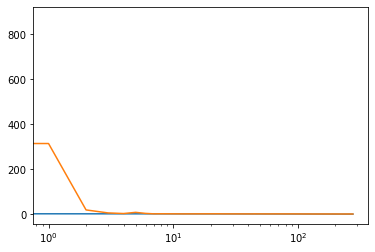

In [20]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

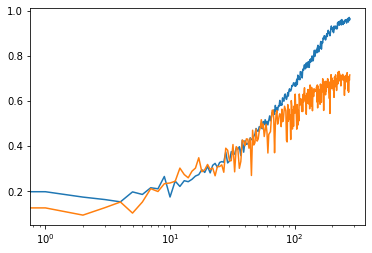

In [21]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])

In [22]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [23]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:01:36 2020 Finding Nearest Neighbors
Sun Aug  9 23:01:36 2020 Building RP forest with 15 trees
Sun Aug  9 23:01:38 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 23:01:49 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:01:52 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 23:02:18 2020 Finished embedding


In [24]:
predictions = model.predict(X_train)

In [25]:
mask = np.array(np.argmax(predictions, axis=1)) != Y_train.flatten()

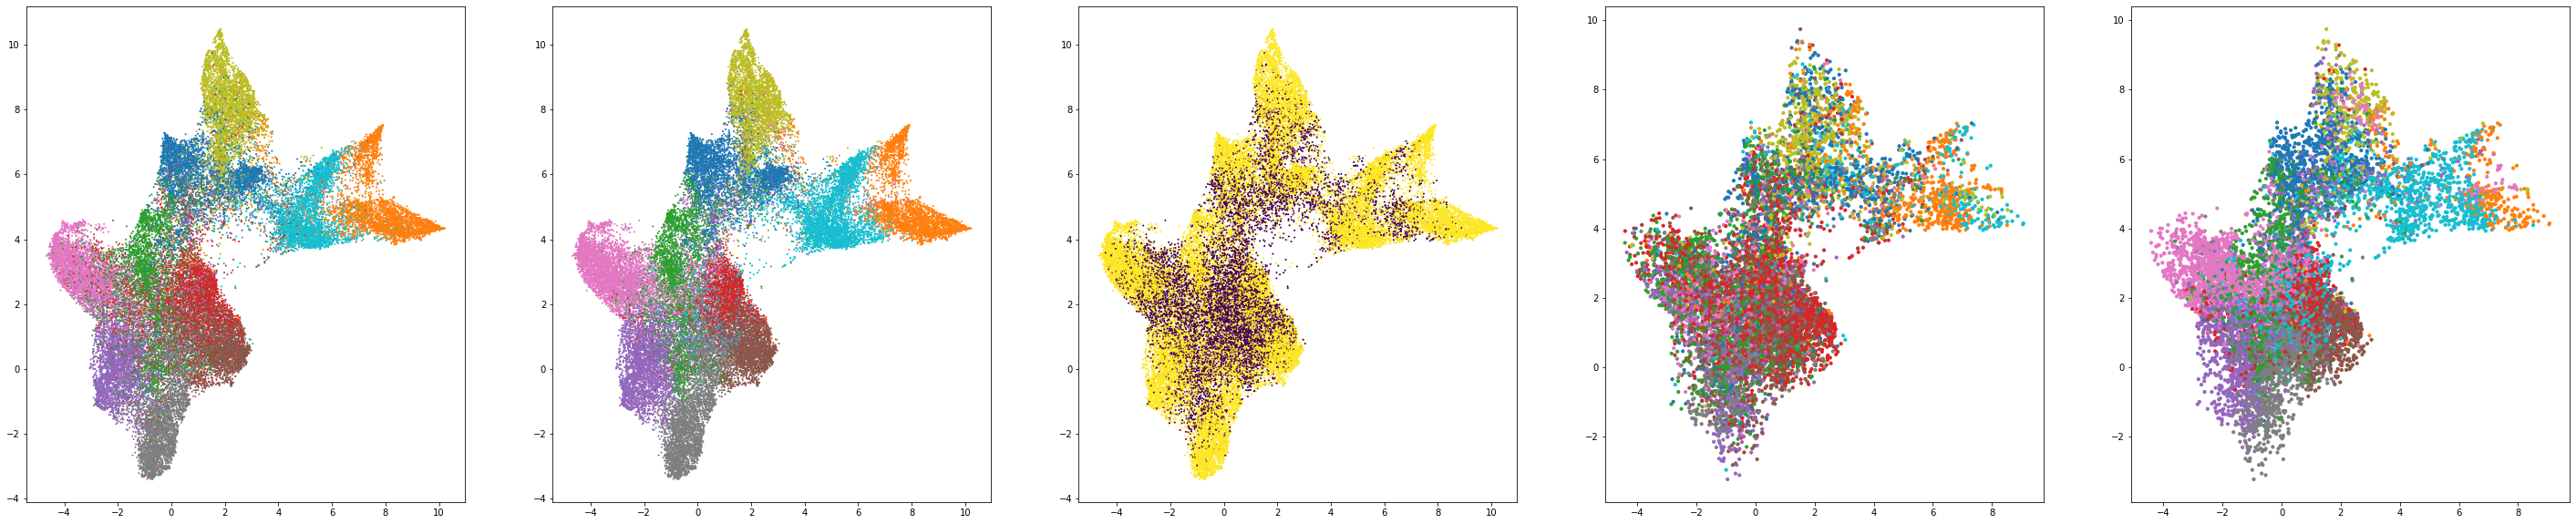

In [26]:
fig, axs = plt.subplots(ncols = 5, figsize=(50,10))
axs[0].scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[2].scatter(embedding[:, 0], embedding[:, 1], c=np.array(np.argmax(predictions, axis=1)) == Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.viridis)
axs[3].scatter(embedding[mask, 0], embedding[mask, 1], c=Y_train.flatten()[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)
axs[4].scatter(embedding[mask, 0], embedding[mask, 1], c=np.argmax(predictions, axis=1)[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)

### save results

In [27]:
# save score, valid embedding, weights, results

In [28]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [29]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [30]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [31]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [32]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [33]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [41]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [34]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 1.4848 - accuracy: 0.7142


In [35]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:31:07 2020 Finding Nearest Neighbors
Mon Aug 10 09:31:07 2020 Building RP forest with 15 trees
Mon Aug 10 09:31:07 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Mon Aug 10 09:31:09 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:31:09 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:32:04 2020 Finished embedding


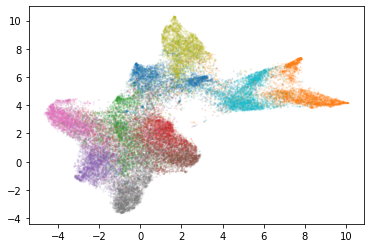

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)